In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import astropy.cosmology as cos
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
mdc = pd.read_feather('data/MDC11_chirp_and_skymap_info.fthr')
mdc['num_detectors'] = mdc['IFOS'].apply(lambda x: len(x.split(',')))
mdc['z'] = cos.z_at_value(cosmo.luminosity_distance, mdc['Dist_mean'].values * u.Mpc, method='bounded').value
mdc.columns

Index(['superevent', 'events', 'mass1_inj', 'mass2_inj', 'mass1', 'mass2',
       'spin1z_inj', 'spin2z_inj', 'spin1z', 'spin2z', 'mchirp_inj', 'mchirp',
       'SNR', 'FAR', 'distance_inj', 'z_inj', 'IFOS', 'mchirp_left_bin_LL',
       'mchirp_right_bin_LL', 'mchirp_left_bin_PE', 'mchirp_right_bin_PE',
       'Area50', 'Area90', 'Dist_mean', 'Searched_area', 'Searched_prob',
       'Separation', 'RA_max', 'DEC_max', 'num_detectors', 'z'],
      dtype='object')

In [49]:
# is far is in units of false alarms / year ??
# unsure if this is handling the way binning works correctly

would_req_gwemopt_plan = mdc[(mdc['Area90'] < 1000) 
                             & (mdc['FAR'] < 0.1)
                             & (mdc['mchirp_left_bin_PE'] >= 22)]
print(f'{len(would_req_gwemopt_plan)} / {len(mdc)} events would generate gwemopt plan for')

165 / 1285 events would generate gwemopt plan for


In [ ]:
# TODO: generate ZTF Gwemopt observing plans for each of these events, and check whether we would trigger
# require >50% probability covered and total plan time < 5400 seconds
# would need to generate a date of detection for each event to do this

In [22]:
# plot parameter space coverage

def plot_histograms(column_name, df1=mdc, df2=would_req_gwemopt_plan, label1='All', label2='Request Plan', bins=30, logscale=True):
    plt.hist(df1[column_name], bins=bins, alpha=0.5, color='blue', label=label1, edgecolor='black')
    plt.hist(df2[column_name], bins=bins, alpha=0.5, color='orange', label=label2, edgecolor='black')
    if logscale:
        plt.yscale('log')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')
    plt.legend()
    plt.show()

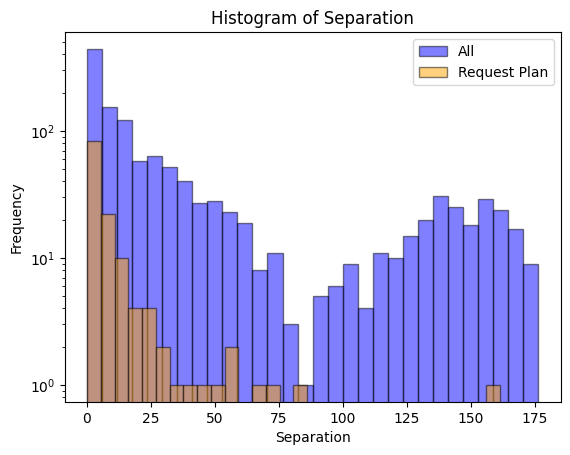

In [23]:
plot_histograms('Separation')

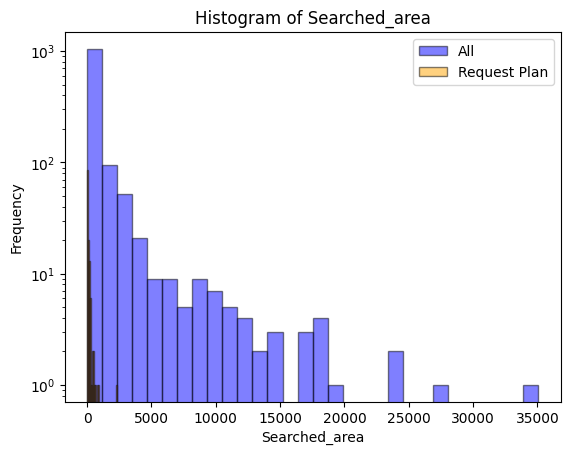

In [24]:
plot_histograms('Searched_area')

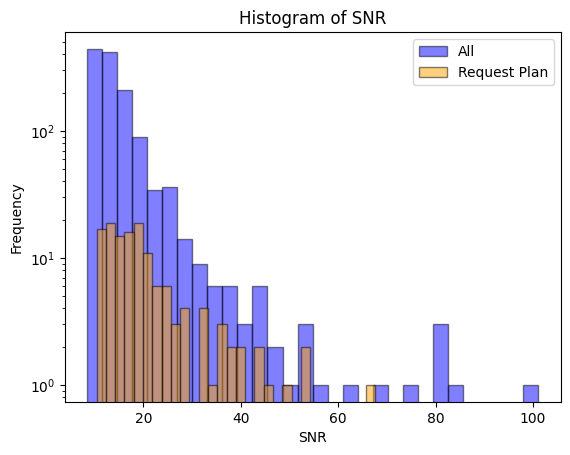

In [25]:
plot_histograms('SNR')

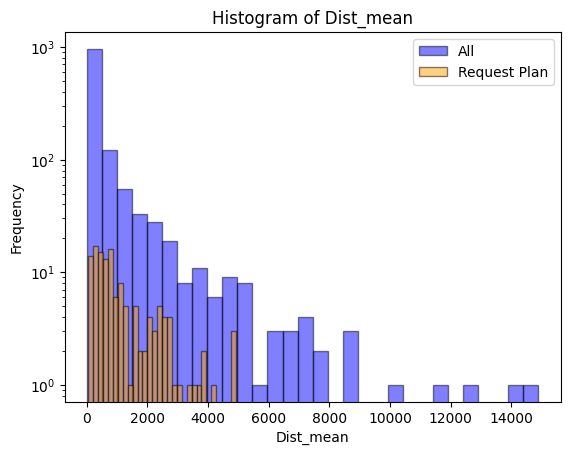

In [26]:
plot_histograms('Dist_mean')

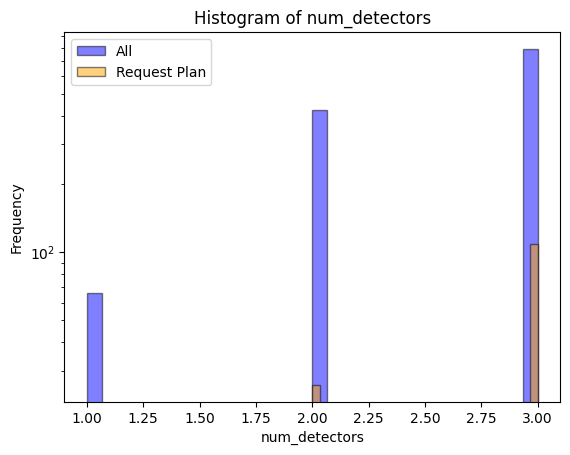

In [27]:
plot_histograms('num_detectors')

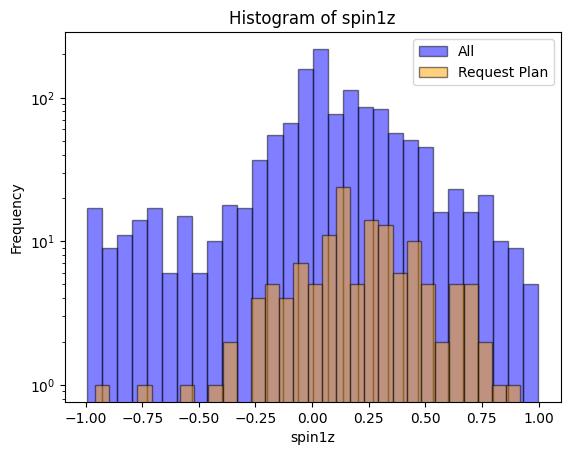

In [28]:
plot_histograms('spin1z')

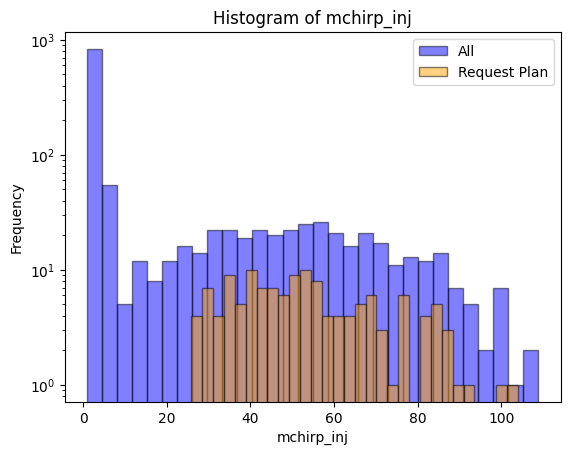

In [29]:
plot_histograms('mchirp_inj')

Mean Absolute Error (MAE): 20.877894063030634
Mean Squared Error (MSE): 2163.550264353128
Root Mean Squared Error (RMSE): 46.513979235850464


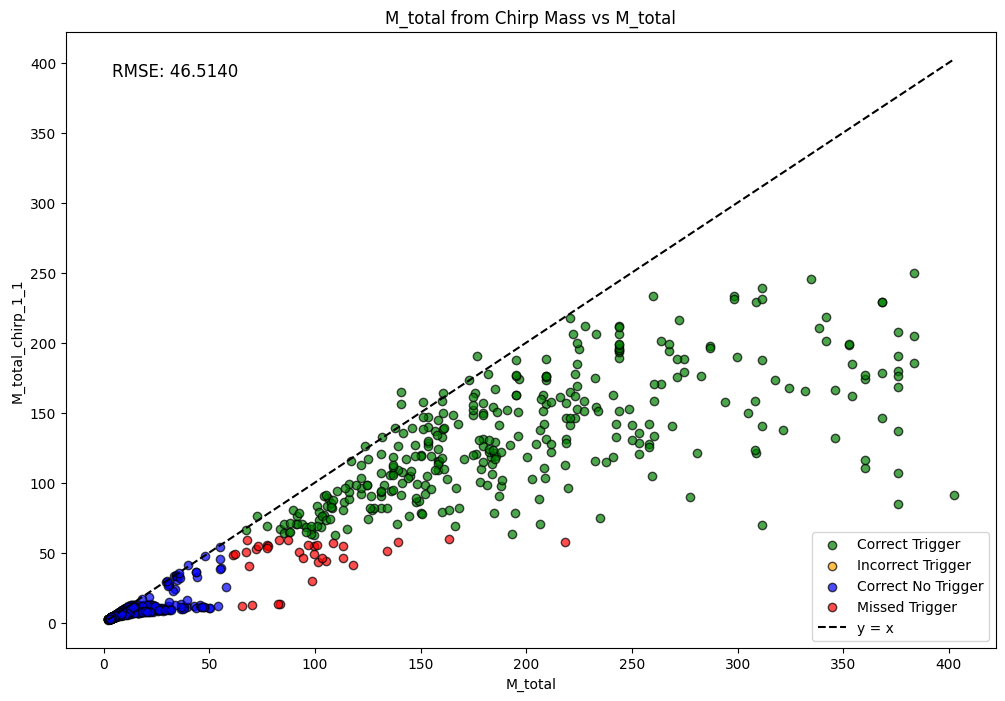

In [47]:
# do analysis of error when we assume ratio is 1:1
# I dont remember exactly how we discussed showing this

mdc['M_total'] = mdc['mass1'] + mdc['mass2']
# m_chirp = (M1 * M2)^(3/5) / (M1 + M2)^(1/5)
mdc['M_total_chirp_1_1'] = mdc['mchirp_inj'] * 2**(6/5)

#error metrics
mae = mean_absolute_error(mdc['M_total'], mdc['M_total_chirp_1_1'])
mse = mean_squared_error(mdc['M_total'], mdc['M_total_chirp_1_1'])
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


# label conditions
conditions = [
    (mdc['M_total_chirp_1_1'] > 60) & (mdc['M_total'] > 60),  # True Positive
    (mdc['M_total_chirp_1_1'] > 60) & (mdc['M_total'] <= 60), # False Positive
    (mdc['M_total_chirp_1_1'] <= 60) & (mdc['M_total'] <= 60),# True Negative
    (mdc['M_total_chirp_1_1'] <= 60) & (mdc['M_total'] > 60)  # False Negative
]
labels = ['Correct Trigger', 'Incorrect Trigger', 'Correct No Trigger', 'Missed Trigger']
mdc['Category'] = np.select(conditions, labels, default='Uncategorized')
colors = {
    'Correct Trigger': 'green',
    'Incorrect Trigger': 'orange',
    'Correct No Trigger': 'blue',
    'Missed Trigger': 'red'
}

#plot
plt.figure(figsize=(12, 8))
for label, color in colors.items():
    subset = mdc[mdc['Category'] == label]
    plt.scatter(subset['M_total'], subset['M_total_chirp_1_1'], alpha=0.7, edgecolors='k', label=label, color=color)
x = np.linspace(min(mdc['M_total']), max(mdc['M_total']), 100)
plt.plot(x, x, color='black', linestyle='--', label='y = x')
plt.xlabel('M_total')
plt.ylabel('M_total_chirp_1_1')
plt.title('M_total from Chirp Mass vs M_total')
plt.text(0.05, 0.95, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.show()

In [10]:
# train mlp

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
d = mdc[['mchirp_inj', 'Dist_mean', 'z', 'Area90', 'FAR']].to_numpy().T
d[0] = np.log10(d[0])  # log chirp mass
d[1] = np.log10(d[1])  # log dl
d[2] = np.log10(1 + d[2])  # log (1 + z)
d[3] = np.log10(d[3])  # log a_90
d[4] = np.log10(d[4])  # log far 

# Training data
#d[2] = d[2] - np.log10(168.)  # log (dl / dl_bns) Mpc
X = np.array([d[1], d[2], d[4]]).T  # training on log (dl/dl_bns) (Mpc), log(z+1), log(FAR)
y = d[0]  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = MLPRegressor(random_state=1, max_iter=10000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Undo log scale for mass values
y_true_linear = 10**y_test
y_pred_linear = 10**y_pred

# Evaluate the model
rmse_1 = np.sqrt(mean_squared_error(y_true_linear, y_pred_linear))
r2_1 = r2_score(y_true_linear, y_pred_linear)

print(f"RMSE: {rmse_1}")
print(f"R^2: {r2_1}")

RMSE: 23.035253051677344
R^2: 0.29771518979293954


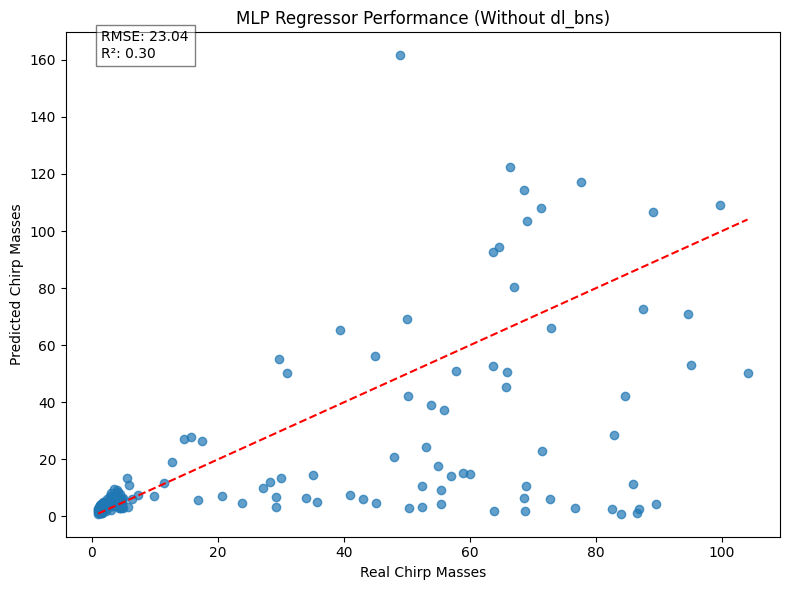

In [16]:
# Plot performance
plt.figure(figsize=(8, 6))
plt.scatter(y_true_linear, y_pred_linear, alpha=0.7)
plt.plot([min(y_true_linear), max(y_true_linear)], [min(y_true_linear), max(y_true_linear)], color='red', linestyle='--')
plt.xlabel('Real Chirp Masses')
plt.ylabel('Predicted Chirp Masses')
plt.title('MLP Regressor Performance (Without dl_bns)')
plt.text(0.05, 0.95, f'RMSE: {rmse_1:.2f}\nR²: {r2_1:.2f}', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
plt.show()